In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statistics
import warnings
warnings.filterwarnings('ignore')
import sklearn.model_selection as ms
from scipy.stats import norm
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, Lasso, ElasticNet 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold 
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn import linear_model
%matplotlib inline

In [151]:
#Import the datasets

#Unchanged dataset
df1 = pd.read_csv('train.csv')

#Dataset with dummified values
df2 = pd.read_csv('train_dummy_ordinal.csv')

#Remove ID column
df1.drop("Id", axis = 1, inplace = True)
df2.drop("Id", axis = 1, inplace = True)

In [152]:
df2.head()

,Unnamed: 0,LotFrontage,LotArea,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,SaleType_conlw,SaleType_cwd,SaleType_new,SaleType_oth,SaleType_wd,SaleCondition_adjland,SaleCondition_alloca,SaleCondition_family,SaleCondition_normal,SaleCondition_partial
0,0,65,8450,3,7,5,2003,2003,196,4,...,0,0,0,0,1,0,0,0,1,0
1,1,80,9600,3,6,8,1976,1976,0,3,...,0,0,0,0,1,0,0,0,1,0
2,2,68,11250,3,7,5,2001,2002,162,4,...,0,0,0,0,1,0,0,0,1,0
3,3,60,9550,3,7,5,1915,1970,0,3,...,0,0,0,0,1,0,0,0,0,0
4,4,84,14260,3,8,5,2000,2000,350,4,...,0,0,0,0,1,0,0,0,1,0


## Exploratory Data Analysis

mu = 180921.20, sigma = 79415.29


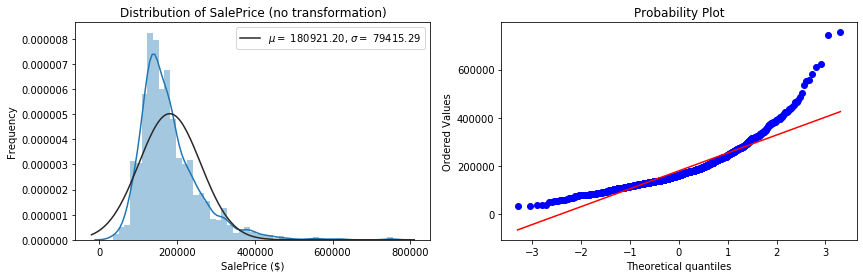

In [48]:
#Check distribution of SalePrice and QQ plot 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 4))
sns.distplot(df['SalePrice'], fit=norm, ax = ax1)

#Find mean and standard deviation
(mu, sigma) = norm.fit(df1['SalePrice'])
print('mu = {:.2f}, sigma = {:.2f}'.format(mu, sigma))

#Set labels and legend 
ax1.legend(['$\mu=$ {:.2f}, $\sigma=$ {:.2f}'.format(mu, sigma)],loc='best')
ax1.set_xlabel('SalePrice ($)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of SalePrice (no transformation)')

#QQ plot
ax2 = plt.subplot(122)
res = stats.probplot(df1['SalePrice'], plot=plt)
plt.show()

In [77]:
#Transform SalePrice using log 
y_log = np.log1p(df1['SalePrice'])

mu = 12.02, sigma = 0.40


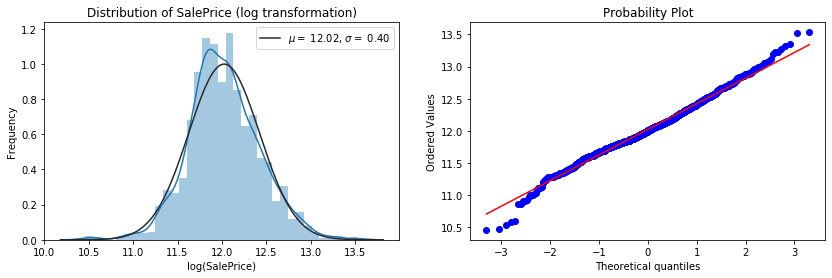

In [61]:
#Check distribution of log-transformed SalePrice
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 4))
sns.distplot(y_log, fit=norm, ax = ax1)

#Find mean and standard deviation
(mu, sigma) = norm.fit(y_log)
print('mu = {:.2f}, sigma = {:.2f}'.format(mu, sigma))

#Set labels and legend 
ax1.legend(['$\mu=$ {:.2f}, $\sigma=$ {:.2f}'.format(mu, sigma)],loc='best')
ax1.set_xlabel('log(SalePrice)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of SalePrice (log transformation)')

#QQ plot
ax2 = plt.subplot(122)
res = stats.probplot(y_log, plot=plt)
plt.show()

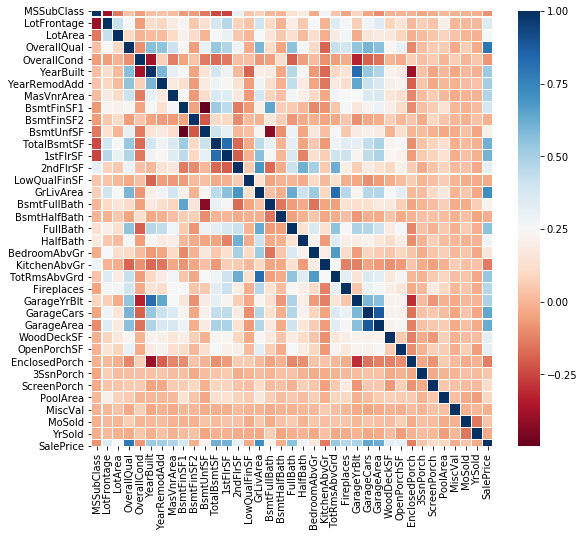

In [153]:
#Create a correlation heatmap 
corrmat = df1.corr() 
colormap = plt.cm.RdBu
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(corrmat, ax = ax, cmap =colormap, linewidths = 0.1)

In [54]:
#Check which features have the highest correlation with each other
corr_features = corrmat.unstack()
corr_features[(abs(corr_features)>0.6) & (abs(corr_features) < 1)]

OverallQual   GarageCars      0.600671
              SalePrice       0.790982
YearBuilt     GarageYrBlt     0.825667
YearRemodAdd  GarageYrBlt     0.642277
BsmtFinSF1    BsmtFullBath    0.649212
TotalBsmtSF   1stFlrSF        0.819530
              SalePrice       0.613581
1stFlrSF      TotalBsmtSF     0.819530
              SalePrice       0.605852
2ndFlrSF      GrLivArea       0.687501
              HalfBath        0.609707
              TotRmsAbvGrd    0.616423
GrLivArea     2ndFlrSF        0.687501
              FullBath        0.630012
              TotRmsAbvGrd    0.825489
              SalePrice       0.708624
BsmtFullBath  BsmtFinSF1      0.649212
FullBath      GrLivArea       0.630012
HalfBath      2ndFlrSF        0.609707
BedroomAbvGr  TotRmsAbvGrd    0.676620
TotRmsAbvGrd  2ndFlrSF        0.616423
              GrLivArea       0.825489
              BedroomAbvGr    0.676620
GarageYrBlt   YearBuilt       0.825667
              YearRemodAdd    0.642277
GarageCars    OverallQual

In [116]:
#Create new features

#Combine bath variables into TotalBathrooms to check if correlation is higher with SalePrice
df['TotalBathrooms'] = df['FullBath'] + (df['HalfBath'] * 0.5) + df['BsmtFullBath'] + (df['BsmtHalfBath'] * 0.5)

#Combine porch variables except WoodenDeck to check if correlation is higher with SalePrice
df['TotalPorch'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']

#Combine square footage above and below ground to give total square footage of the house
df['TotalSqrFeet'] = df['GrLivArea'] + df['TotalBsmtSF']

## Skewed Features

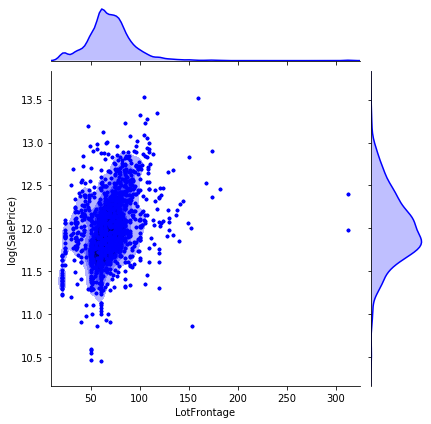

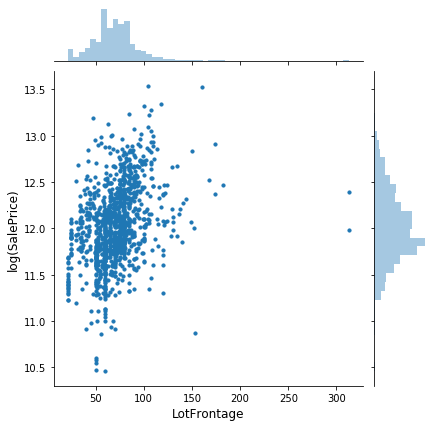

In [47]:
#Check which features in the dataset are skewed 
g1 = sns.jointplot(df['LotFrontage'], y_log, data=df, kind="kde", color="b")
g1.plot_joint(plt.scatter, c="b", s=30, linewidth=1, marker=".")
g1.ax_joint.collections[0].set_alpha(0)
g1.set_axis_labels("LotFrontage", "log(SalePrice)")

g2 = sns.jointplot(df['LotFrontage'],y_log, s = 10)
g1.plot_joint(plt.scatter, c="b", s=30, linewidth=1, marker=".")
g2.set_axis_labels('LotFrontage', 'log(SalePrice)', fontsize=12)

In [117]:
#Check how skewed the numerical features are
num_features = df.dtypes[df.dtypes != "object"].index
skewed_features = df[num_features].apply(lambda x: skew(x)).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_features})
skewness


Skew in numerical features: 



,Skew
RoofMatl_membran,38.170678
MiscFeature_tenc,38.170678
Exterior2nd_cblock,38.170678
Exterior1st_imstucc,38.170678
Exterior1st_cblock,38.170678
...,...
Functional,-4.907166
Heating_gasa,-6.530498
RoofMatl_compshg,-7.291912
Condition2_norm,-9.713069


In [118]:
#Check how many skewed features above 0.75 there are.  0.75 is chosen as the baseline for moderate-severe skewness.
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to BoxCox transform".format(skewness.shape[0]))
skewed_feats = skewness.index

lam = 0.15
for x in skewed_feats:
    df[x] = boxcox1p(df[x], lam)
    df[x] += 1

There are 229 skewed numerical features to BoxCox transform


In [144]:
#Final changes to dataset before hyperparameter tuning.  We need to drop SalePrice
y = df['SalePrice'].reset_index(drop=True)
X = df.drop('SalePrice', axis =1)
#df.drop("Id", axis = 1, inplace = True)
#X = df.iloc[:len(y_log),:]


In [145]:
X

,Unnamed: 0,LotFrontage,LotArea,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,SaleType_oth,SaleType_wd,SaleCondition_adjland,SaleCondition_alloca,SaleCondition_family,SaleCondition_normal,SaleCondition_partial,TotalBathrooms,TotalPorch,TotalSqrFeet
0,1.000000,6.831328,20.212182,2.540963,3.440268,3.055642,15.187527,15.187527,9.059126,2.820334,...,1.0,1.730463,1.0,1.0,1.0,1.730463,1.0,2.687259,6.714669,15.976591
1,1.730463,7.221214,20.712205,2.540963,3.259674,3.602594,15.145138,15.145138,1.000000,2.540963,...,1.0,1.730463,1.0,1.0,1.0,1.730463,1.0,2.378202,1.000000,15.923100
2,2.194318,6.914940,21.347241,2.540963,3.440268,3.055642,15.184404,15.185966,8.646538,2.820334,...,1.0,1.730463,1.0,1.0,1.0,1.730463,1.0,2.687259,6.053371,16.149678
3,2.540963,6.684507,20.691553,2.540963,3.440268,3.055642,15.047529,15.135652,1.000000,2.540963,...,1.0,1.730463,1.0,1.0,1.0,1.000000,1.0,2.194318,10.080098,15.857121
4,2.820334,7.314735,22.325160,2.540963,3.602594,3.055642,15.182841,15.182841,10.391827,2.820334,...,1.0,1.730463,1.0,1.0,1.0,1.730463,1.0,2.687259,7.314735,16.852312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,14.211803,6.744420,19.960528,2.540963,3.259674,3.055642,15.181278,15.182841,1.000000,2.540963,...,1.0,1.730463,1.0,1.0,1.0,1.730463,1.0,2.378202,5.969939,16.019350
1456,14.213850,7.337529,21.994868,2.540963,3.259674,3.259674,15.148295,15.164038,8.003881,2.540963,...,1.0,1.730463,1.0,1.0,1.0,1.730463,1.0,2.540963,1.000000,17.118017
1457,14.215896,6.859551,20.476345,2.540963,3.440268,3.750250,15.089451,15.192207,1.000000,3.055642,...,1.0,1.730463,1.0,1.0,1.0,1.730463,1.0,2.194318,6.684507,17.000045
1458,14.217941,6.914940,20.760176,2.540963,3.055642,3.259674,15.103852,15.176584,1.000000,2.540963,...,1.0,1.730463,1.0,1.0,1.0,1.730463,1.0,2.194318,7.881187,15.418948


## Train/Test Split and K-Fold CV

In [120]:
#Train, test, split the data and then save the resulting files to a csv file
random.seed(4)
X_train, X_test, y_train, y_test = train_test_split(X_, y_log, test_size=0.2, random_state = 4)
#X_train.to_csv('data/X_train.csv')
#y_train.to_csv('data/y_train.csv')
#X_test.to_csv('data/X_test.csv')
#y_test.to_csv('data/y_test.csv')

In [121]:
#K-Fold with 5 splits set to an arbitrary random state
kf = KFold(n_splits = 5, shuffle = True, random_state = 4)

In [122]:
#Create a function to return RMSE for each inputed model after performing K-Fold CV
def kf_rmse(model):
    kf = KFold(n_splits = 5, shuffle=True, random_state=4).get_n_splits(X_train)
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf))
    return(rmse)

## Ridge Regression

In [132]:
#Ridge model object and parameters
ridge = linear_model.Ridge(normalize=True)
ridge = ridge.set_params(random_state=4)

#Train the ridge model
ridge.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=4, solver='auto', tol=0.001)

In [133]:
#First predictions using X_train set
ridge_pred = ridge.predict(X_train)

In [135]:
#Calculate the MSE and RMSE using y_train
error = abs(np.expm1(ridge_pred) - np.expm1(y_train))
print('MSE :', mean_squared_error(y_train, ridge_pred)) 
print('RMSE :', np.sqrt(mean_squared_error(y_train, ridge_pred)))

MSE : 0.017578672647815034
RMSE : 0.13258458676563817


In [136]:
#Tune the hyperparameters for ridge
alphas = 100**np.linspace(10,-2,1000)*0.5
param_grid_ridge = {"max_iter": [5, 10, 20], "alpha": alphas}
grid_search_ridge = ms.GridSearchCV(ridge, param_grid_ridge, scoring= 'neg_mean_squared_error', 
                                    cv= kf, n_jobs=-1, return_train_score = True)
grid_search_ridge.fit(X_train, y_train)
%time grid_search_ridge.fit(X_train, y_train)

CPU times: user 18.8 s, sys: 765 ms, total: 19.6 s
Wall time: 1min 52s


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=True, random_state=4,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': array([5.00000000e+19, 4.73092410e+19, 4.47632856e+19, 4.23543413e+19,
       4.00750348e+19, 3.79183...
       1.14638466e-04, 1.08469176e-04, 1.02631888e-04, 9.71087341e-05,
       9.18828100e-05, 8.69381200e-05, 8.22595294e-05, 7.78327180e-05,
       7.36441362e-05, 6.96809637e-05, 6.59310701e-05, 6.23829776e-05,
       5.90258264e-05, 5.58493409e-05, 5.28437986e-05, 5.00000000e-05]),
                         'max_iter': [5, 10, 20]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [137]:
#Get the best parameters from the tuning
grid_search_ridge.best_params_

{'alpha': 0.46018659983090965, 'max_iter': 5}

In [139]:
#Prediction using the tuned parameters
grid_ridge = grid_search_ridge.best_estimator_

In [140]:
#Prediction using tuned hyperparameters
grid_ridge_pred = grid_ridge.predict(X_train)

# Calculate the absolute errors
error = abs(np.expm1(grid_ridge_pred) - np.expm1(y_train))

#Calculate the MSE and RMSE using y_train 
print('Mean Squared Error (MSE):', mean_squared_error(y_train, grid_ridge_pred))
print('Root Mean Square Error (RMSE):', np.sqrt(mean_squared_error(y_train, grid_ridge_pred)))

Mean Squared Error (MSE): 0.014962938795930804
Root Mean Square Error (RMSE): 0.12232309183441532


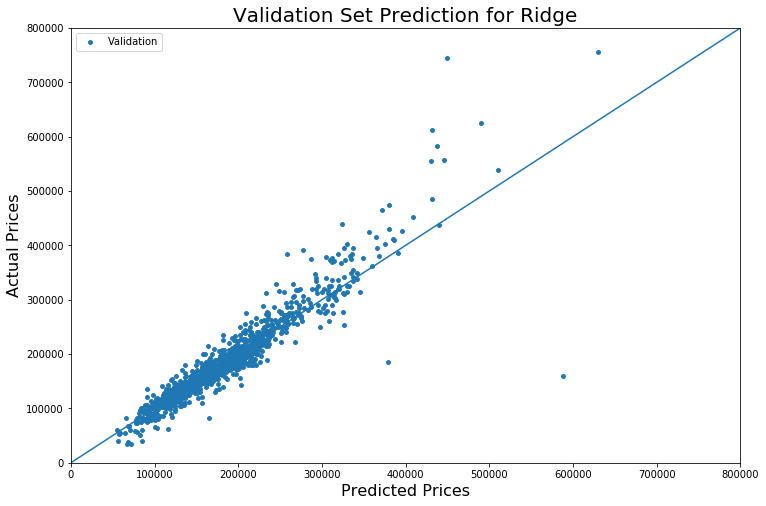

In [142]:
#Plot of the training vs. validation data
#y_train_lasso = lasso.predict(X_train)
y_val_ridge = grid_ridge.predict(X_train)

plt.figure(figsize=(12,8))
plt.scatter(np.expm1(y_val_ridge), np.expm1(y_train), marker="o", s=15, label="Validation")
plt.title("Validation Set Prediction for Ridge", fontsize=20)
plt.xlabel("Predicted Prices", fontsize = 16)
plt.ylabel("Actual Prices", fontsize = 16)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.legend(loc = "upper left")
plt.plot([0, 800000], [0, 800000])
plt.show()

In [143]:
#Check which features are most influential for Ridge prediction 
coeff = pd.DataFrame({"feature":X_train.columns,"coeff":grid_ridge.coef_})
coeff = coeff.sort_values(by = 'coeff', ascending = False)

print(coeff[coeff.coeff>0].shape)
coeff[coeff.coeff>0]

(133, 2)


,feature,coeff
121,Condition2_posa,2.048720e-01
148,RoofMatl_wdshngl,1.870399e-01
143,RoofMatl_membran,1.562796e-01
107,Neighborhood_stonebr,1.210604e-01
216,SaleType_cwd,1.044044e-01
...,...,...
23,LowQualFinSF,1.763405e-05
1,LotFrontage,1.392214e-05
18,BsmtUnfSF,4.821200e-06
2,LotArea,1.159562e-06


## Lasso Regression

In [123]:
#Lasso model object and parameters
lasso = linear_model.Lasso(normalize=True)
lasso = lasso.set_params(random_state=4)

#Train the lasso model
lasso.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=4, selection='cyclic',
      tol=0.0001, warm_start=False)

In [124]:
#First predictions using X_train set
lasso_pred = lasso.predict(X_train)    

In [125]:
#Calculate the MSE and RMSE using y_train 
error = abs(np.expm1(lasso_pred) - np.expm1(y_train))
print('MSE :', mean_squared_error(y_train, lasso_pred)) 
print('RMSE :', np.sqrt(mean_squared_error(y_train, lasso_pred)))

MSE : 0.16341843071646808
RMSE : 0.40425045543136756


In [126]:
#Tune the hyperparameters for lasso 
alphas = 100**np.linspace(10,-2,1000)*0.5
param_grid_lasso = {"max_iter": [5, 10, 20], "alpha": alphas}
grid_search_lasso = ms.GridSearchCV(lasso, param_grid_lasso, scoring= 'neg_mean_squared_error', 
                                    cv= kf, n_jobs=-1, return_train_score = True)
grid_search_lasso.fit(X_train, y_train)
%time grid_search_lasso.fit(X_train, y_train)

CPU times: user 16.7 s, sys: 554 ms, total: 17.3 s
Wall time: 1min 10s


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=True, positive=False,
                             precompute=False, random_state=4,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': array([5.00000000e+19, 4.73092410e+...
       1.14638466e-04, 1.08469176e-04, 1.02631888e-04, 9.71087341e-05,
       9.18828100e-05, 8.69381200e-05, 8.22595294e-05, 7.78327180e-05,
       7.36441362e-05, 6.96809637e-05, 6.59310701e-05, 6.23829776e-05,
       5.90258264e-05, 5.58493409e-05, 5.28437986e-05, 5.00000000e-05]),
                         'max_iter': [5, 10, 20]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [127]:
#Get the best parameters from the tuning
grid_search_lasso.best_params_

{'alpha': 0.00019932905367902194, 'max_iter': 20}

In [128]:
#Prediction using the tuned parameters
grid_lasso = grid_search_lasso.best_estimator_

In [129]:
#Prediction using tuned hyperparameters
grid_lasso_pred = grid_lasso.predict(X_train)

# Calculate the absolute errors
error = abs(np.expm1(grid_lasso_pred) - np.expm1(y_train))

#Calculate the MSE and RMSE using y_train 
print('Mean Squared Error (MSE):', mean_squared_error(y_train, grid_lasso_pred))
print('Root Mean Square Error (RMSE):', np.sqrt(mean_squared_error(y_train, grid_lasso_pred)))

Mean Squared Error (MSE): 0.016105911951563186
Root Mean Square Error (RMSE): 0.1269090696190118


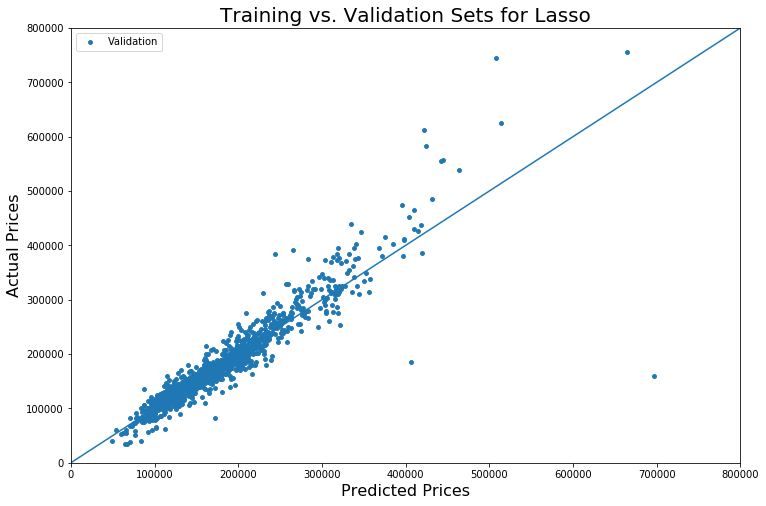

In [130]:
#Plot of the training vs. validation data
#y_train_lasso = lasso.predict(X_train)
y_val_lasso = grid_lasso.predict(X_train)

plt.figure(figsize=(12,8))
#plt.scatter(np.expm1(y_train_lasso), np.expm1(y_train), marker="o", s=15, label = "Training")
plt.scatter(np.expm1(y_val_lasso), np.expm1(y_train), marker="o", s=15, label="Validation")
plt.title("Training vs. Validation Sets for Lasso", fontsize=20)
plt.xlabel("Predicted Prices", fontsize = 16)
plt.ylabel("Actual Prices", fontsize = 16)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.legend(loc = "upper left")
plt.plot([0, 800000], [0, 800000])
plt.show()

In [131]:
#Check which features are most influential for Lasso prediction 
coeff = pd.DataFrame({"feature":X_train.columns,"coeff":grid_lasso.coef_})
coeff = coeff.sort_values(by = 'coeff', ascending = False)

print(coeff[coeff.coeff>0].shape)
coeff[coeff.coeff>0]

(52, 2)


,feature,coeff
107,Neighborhood_stonebr,9.302614e-02
101,Neighborhood_nridght,8.316397e-02
191,CentralAir_y,7.583228e-02
106,Neighborhood_somerst,6.944037e-02
92,Neighborhood_crawfor,6.511597e-02
99,Neighborhood_noridge,6.155265e-02
38,GarageCars,5.932933e-02
217,SaleType_new,5.529335e-02
4,OverallQual,5.501664e-02
148,RoofMatl_wdshngl,4.825995e-02


## Random Forest

In [ ]:
#Random forest object and parameters
rforest = RandomForestRegressor()
rforest.set_params(random_state=4)

#Train the random forest model
rforest.fit(X_train, y_train)

#R^2 value of initial training set

In [ ]:
#Tune the hyperparameters for random forest
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score

param_grid = {'max_depth': [20, 25, 30],
             'max_features': ['auto', 'sqrt', 'log2'],
             'min_samples_split': [2, 3, 4],
             'min_samples_leaf': [1, 3, 5],
             'n_estimators': [500, 750, 1000, 1250, 1500]}

In [ ]:
#Use grid search on the random forest object 
grid_search_rforest = ms.GridSearchCV(rforest, param_grid, scoring = 'neg_mean_squared_error', cv=kf, 
                                      n_jobs=-1, return_train_score=True)

## Gradient Boost

In [ ]:
#Gradient boost object and parameters
gb = GradientBoostingRegressor()
gb.set_params(random_state=4)

#Train the gradient boost model
gb.fit(X_train, y_train)

#R^2 value of initial training set
print("R^2 : %.5f" gb.score(X_train, y_train))